In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install -q segmentation-models-pytorch==0.4.0 timm==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6

In [21]:
import os, time, numpy as np
from PIL import Image
from tqdm import tqdm
import torch, torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import timm
import segmentation_models_pytorch as smp

In [22]:
def patchify_image(img, mask, patch_size=512, overlap=128):
    patches = []
    step = patch_size - overlap
    H, W = img.shape[:2]
    for y in range(0, H - patch_size + 1, step):
        for x in range(0, W - patch_size + 1, step):
            img_patch = img[y:y+patch_size, x:x+patch_size]
            mask_patch = mask[y:y+patch_size, x:x+patch_size]
            patches.append((img_patch, mask_patch))
    return patches


class XBDDataset(Dataset):
    def __init__(self, root_dir, patch_size=512, overlap=128, transform=None, load_patches=True):
        self.img_dir = os.path.join(root_dir, "images")
        self.mask_dir = os.path.join(root_dir, "targets")
        self.patch_size = patch_size
        self.overlap = overlap
        self.transform = transform
        self.samples = []
        self.load_patches = load_patches  # False = lazy (for test)

        img_files = [f for f in os.listdir(self.img_dir) if f.endswith("_post_disaster.png")]
        print(f" Creating patch index from: {root_dir}")
        for f in tqdm(img_files):
            img_path = os.path.join(self.img_dir, f)
            mask_path = os.path.join(self.mask_dir, f.replace(".png", "_target.png"))
            if not os.path.exists(mask_path):
                continue
            img = np.array(Image.open(img_path))
            H, W = img.shape[:2]
            step = patch_size - overlap
            for y in range(0, H - patch_size + 1, step):
                for x in range(0, W - patch_size + 1, step):
                    self.samples.append((img_path, mask_path, x, y))
        print(f"Total patches indexed: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path, x, y = self.samples[idx]
        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        img = img[y:y+self.patch_size, x:x+self.patch_size]
        mask = mask[y:y+self.patch_size, x:x+self.patch_size]
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img, mask = augmented["image"], augmented["mask"]
        return img, mask.long()

In [23]:
train_transforms = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(0.2, 0.2),
    A.GaussNoise(var_limit=(10.0, 50.0)),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transforms = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_root = "/kaggle/input/x-view2/X_view2/train/train"
val_root = "/kaggle/input/x-view2/X_view2/hold/hold"

train_dataset = XBDDataset(train_root, patch_size=256, overlap=64, transform=train_transforms)
val_dataset   = XBDDataset(val_root,   patch_size=256, overlap=64, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,num_workers=4, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

/tmp/ipykernel_39/1891856050.py:6: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0)),


 Creating patch index from: /kaggle/input/x-view2/X_view2/train/train


100%|██████████| 2799/2799 [01:28<00:00, 31.76it/s]


Total patches indexed: 69975
 Creating patch index from: /kaggle/input/x-view2/X_view2/hold/hold


100%|██████████| 933/933 [00:31<00:00, 29.50it/s]

Total patches indexed: 23325


In [24]:
# ===================== Transformer Encoder + Segmentation Head =====================
NUM_CLASSES = 5

model = smp.Unet(
    encoder_name="mit_b2",          # SegFormer-B2 transformer encoder
    encoder_weights="imagenet",     # Pretrained on ImageNet
    in_channels=3,                  # RGB input
    classes=NUM_CLASSES,            # Number of segmentation classes
    activation=None                 # We'll use raw logits for CE + Dice loss
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f" Model initialized on {device}")

# Option 1: Freeze the entire Transformer encoder (train decoder only)
# for name, param in model.encoder.named_parameters():
#     param.requires_grad = False
# print(" Encoder frozen — training decoder only.")

# Option 2 (optional): Unfreeze last two transformer blocks later
for p in model.encoder.parameters():
    p.requires_grad = False

for name, param in model.encoder.named_parameters():
    if "blocks.3.2.mlp" in name:     # only MLP, not attention
        param.requires_grad = True

print("Only MLP of last block unfrozen.")

# ===================== Loss & Optimizer =====================
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.softmax(pred, dim=1)
    target_onehot = F.one_hot(target, num_classes=pred.shape[1]).permute(0,3,1,2).float()
    inter = (pred * target_onehot).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target_onehot.sum(dim=(2,3))
    dice = (2. * inter + smooth) / (union + smooth)
    return 1 - dice.mean()

def weighted_ce_loss(pred, target, weights):
    return F.cross_entropy(pred, target, weight=weights.to(pred.device))

def combined_loss(pred, target, weights, alpha=1.0, beta=0.5):
    ce, dc = weighted_ce_loss(pred, target, weights), dice_loss(pred, target)
    return alpha * ce + beta * dc

weights = torch.tensor([0.2, 1.0, 1.2, 1.3, 1.3])
weights = weights / weights.sum() * len(weights)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

 Model initialized on cuda
Only MLP of last block unfrozen.


In [25]:
from torch.amp import GradScaler, autocast
scaler = GradScaler(device="cuda")

def compute_iou(preds, targets, num_classes=5):
    preds = torch.argmax(preds, dim=1).cpu().numpy()
    targets = targets.cpu().numpy()
    ious = []
    for cls in range(num_classes):
        inter = np.logical_and(preds == cls, targets == cls).sum()
        union = np.logical_or(preds == cls, targets == cls).sum()
        ious.append(np.nan if union == 0 else inter / union)
    return ious

def compute_weighted_f1(preds, targets, num_classes=5):
    preds = torch.argmax(preds, dim=1).cpu().numpy().ravel()
    targets = targets.cpu().numpy().ravel()
    f1_per_class = f1_score(targets, preds, average=None, labels=list(range(num_classes)))
    support = np.array([(targets == i).sum() for i in range(num_classes)])
    weighted_f1 = np.sum(f1_per_class * support) / np.sum(support)
    return weighted_f1, f1_per_class

def train_one_epoch_amp(model, dataloader, optimizer, weights, scaler):
    model.train()
    run_loss = 0
    for imgs, masks in tqdm(dataloader, desc="Training", leave=False):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type="cuda"):
            out = model(imgs)
            loss = combined_loss(out, masks, weights)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        run_loss += loss.item()
    return run_loss / len(dataloader)

# def validate(model, dataloader, weights, max_batches=None):
#     model.eval()
#     val_loss, preds_all, targets_all = 0, [], []
#     with torch.no_grad():
#         for i, (imgs, masks) in enumerate(tqdm(dataloader, desc="Validating", leave=False)):
#             imgs, masks = imgs.to(device), masks.to(device)
#             with autocast(device_type="cuda"):
#                 out = model(imgs)
#                 loss = combined_loss(out, masks, weights)
#             val_loss += loss.item()
#             preds_all.append(out.cpu())
#             targets_all.append(masks.cpu())
#             if max_batches and i+1 >= max_batches: break
#     preds_all, targets_all = torch.cat(preds_all), torch.cat(targets_all)
#     wf1, f1s = compute_weighted_f1(preds_all, targets_all)
#     ious = compute_iou(preds_all, targets_all)
#     return {"val_loss": val_loss/len(dataloader), "weighted_f1": wf1, "f1_per_class": f1s, "iou": ious}
from sklearn.metrics import precision_recall_fscore_support

def update_confusion(confmat, preds_flat, targets_flat, num_classes):
    # preds_flat and targets_flat are 1D numpy arrays of same length
    # we compute bincount on pair ids: i = targets*num_classes + preds
    pairs = targets_flat.astype(np.int64) * num_classes + preds_flat.astype(np.int64)
    counts = np.bincount(pairs, minlength=num_classes*num_classes)
    confmat += counts.reshape((num_classes, num_classes))
    return confmat

def metrics_from_confusion(confmat):
    # confmat: rows = true, cols = pred
    tp = np.diag(confmat).astype(np.float64)
    support = confmat.sum(axis=1).astype(np.float64)           # true counts per class
    pred_sum = confmat.sum(axis=0).astype(np.float64)          # predicted counts per class

    # Precision = TP / predicted positives
    precision = np.divide(tp, pred_sum, out=np.zeros_like(tp), where=pred_sum>0)
    # Recall = TP / actual positives
    recall = np.divide(tp, support, out=np.zeros_like(tp), where=support>0)
    # F1
    f1 = np.divide(2 * precision * recall, precision + recall,
                   out=np.zeros_like(tp), where=(precision+recall)>0)

    # IoU = TP / (TP + FP + FN)  where FP = pred_sum - TP, FN = support - TP
    denom = tp + (pred_sum - tp) + (support - tp)
    iou = np.divide(tp, denom, out=np.zeros_like(tp), where=denom>0)

    # Weighted F1 (same as xBD): weight by support
    total_support = support.sum() if support.sum() > 0 else 1
    weighted_f1 = (f1 * support).sum() / total_support

    return {
        "precision": precision,
        "recall": recall,
        "f1_per_class": f1,
        "support": support,
        "iou_per_class": iou,
        "weighted_f1": weighted_f1
    }
    
def validate_efficient(model, dataloader, weights, num_classes=5, max_batches=None, device=device):
    model.eval()
    confmat = np.zeros((num_classes, num_classes), dtype=np.int64)
    val_loss = 0.0
    batches = 0

    with torch.no_grad():
        for i, (imgs, masks) in enumerate(tqdm(dataloader, desc="Validating", leave=False)):
            imgs, masks = imgs.to(device), masks.to(device)
            with autocast(device_type="cuda"):
                out = model(imgs)
                loss = combined_loss(out, masks, weights)
            val_loss += loss.item()
            # convert to preds (cpu numpy)
            preds = torch.argmax(out, dim=1).cpu().numpy().ravel()
            targets = masks.cpu().numpy().ravel()
            # optionally ignore pixels with label outside [0,num_classes-1]
            mask_valid = (targets >= 0) & (targets < num_classes)
            if mask_valid.sum() == 0:
                # no valid pixels in this batch
                batches += 1
                if max_batches and batches >= max_batches:
                    break
                continue
            preds = preds[mask_valid]
            targets = targets[mask_valid]
            # update confusion efficiently
            confmat = update_confusion(confmat, preds, targets, num_classes)
            batches += 1
            if max_batches and batches >= max_batches:
                break

    if batches == 0:
        return {"val_loss": np.nan, "weighted_f1": 0.0, "f1_per_class": np.zeros(num_classes), "iou": [np.nan]*num_classes}

    metrics = metrics_from_confusion(confmat)
    metrics["val_loss"] = val_loss / batches
    return metrics

In [26]:
# ===================== Training Loop =====================
import gc

NUM_EPOCHS = 5
best_f1, save_path = 0.0, "best_model.pth"

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    t0 = time.time()

    tr_loss = train_one_epoch_amp(model, train_loader, optimizer, weights, scaler)
    metrics = validate_efficient(model, val_loader, weights, num_classes=NUM_CLASSES, max_batches=100)
    scheduler.step()

    print(f"Train {tr_loss:.4f} | Val {metrics['val_loss']:.4f} | "
          f"Weighted F1 {metrics['weighted_f1']:.4f} | "
          f"Time {(time.time()-t0)/60:.1f} min")

    # save best
    if metrics["weighted_f1"] > best_f1:
        best_f1 = metrics["weighted_f1"]
        torch.save(model.state_dict(), save_path)
        print(f" Saved best model (Weighted F1 {best_f1:.4f})")

    # cleanup
    torch.cuda.empty_cache()
    gc.collect()


Epoch 1/5


Train 0.8492 | Val 0.7708 | Weighted F1 0.9232 | Time 28.8 min
 Saved best model (Weighted F1 0.9232)

Epoch 2/5


Train 0.7946 | Val 0.8085 | Weighted F1 0.9314 | Time 28.5 min
 Saved best model (Weighted F1 0.9314)

Epoch 3/5


Train 0.7732 | Val 0.8021 | Weighted F1 0.9293 | Time 29.6 min

Epoch 4/5


Train 0.7597 | Val 0.7781 | Weighted F1 0.9380 | Time 31.1 min
 Saved best model (Weighted F1 0.9380)

Epoch 5/5


Train 0.7494 | Val 0.8112 | Weighted F1 0.9318 | Time 30.7 min


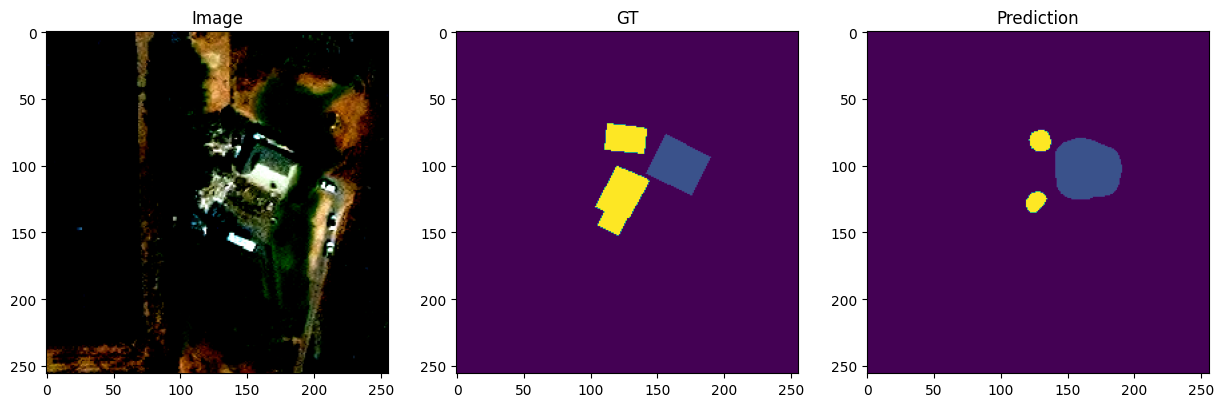

In [27]:
# ===================== Quick Visualization =====================
model.load_state_dict(torch.load(save_path))
model.eval()
imgs, masks = next(iter(val_loader))
imgs, masks = imgs.to(device), masks.to(device)
with torch.no_grad(), autocast(device_type="cuda"):
    preds = model(imgs)
pred_classes = torch.argmax(preds, dim=1)
i = 0
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(imgs[i].permute(1,2,0).cpu()); plt.title("Image")
plt.subplot(1,3,2); plt.imshow(masks[i].cpu()); plt.title("GT")
plt.subplot(1,3,3); plt.imshow(pred_classes[i].cpu()); plt.title("Prediction")
plt.show()

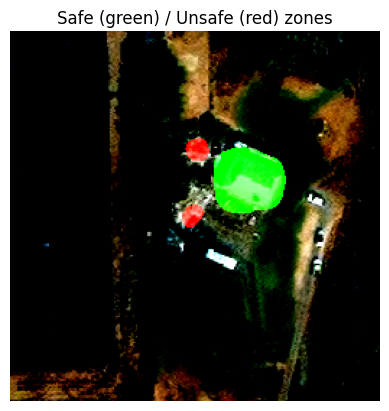

In [28]:
imgs, masks = next(iter(val_loader))
imgs, masks = imgs.to(device), masks.to(device)
with torch.no_grad(), autocast(device_type="cuda"):
    preds = model(imgs)
pred_map = torch.argmax(preds, dim=1)[0].cpu().numpy()

safe_mask   = (pred_map == 1)       # no-damage
unsafe_mask = (pred_map > 1)        # minor/major/destroyed

img_np = imgs[0].permute(1,2,0).cpu().numpy()
overlay = img_np.copy()
overlay[safe_mask] = [0,255,0]
overlay[unsafe_mask] = [255,0,0]

plt.imshow(0.6*img_np + 0.4*overlay)
plt.title("Safe (green) / Unsafe (red) zones")
plt.axis("off")
plt.show()

In [29]:
test_root = "/kaggle/input/x-view2/X_view2/test/test"
test_dataset = XBDDataset(test_root, patch_size=256, overlap=64, transform=val_transforms, load_patches=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False,
                         num_workers=2, pin_memory=True, persistent_workers=False)

model.load_state_dict(torch.load(save_path))
model.eval()

test_metrics = validate_efficient(model, test_loader, weights, num_classes=NUM_CLASSES)
print("\n Test-set results:")
print(f"Loss={test_metrics['val_loss']:.4f} | Weighted F1={test_metrics['weighted_f1']:.4f}")

# After test_metrics is computed
names = ["No Damage", "Minor", "Major", "Destroyed"]

for i, name in enumerate(names):
    cls_idx = i + 1      # shift 1→NoDamage, 2→Minor, 3→Major, 4→Destroyed
    print(f"{name:<12} F1={test_metrics['f1_per_class'][cls_idx]:.4f}  "
          f"Prec={test_metrics['precision'][cls_idx]:.4f}  "
          f"Rec={test_metrics['recall'][cls_idx]:.4f}  "
          f"IoU={test_metrics['iou_per_class'][cls_idx]:.4f}")

 Creating patch index from: /kaggle/input/x-view2/X_view2/test/test


100%|██████████| 933/933 [00:34<00:00, 26.91it/s]


Total patches indexed: 23325



 Test-set results:
Loss=0.6674 | Weighted F1=0.9514
No Damage    F1=0.6132  Prec=0.6318  Rec=0.5958  IoU=0.4422
Minor        F1=0.0000  Prec=0.0000  Rec=0.0000  IoU=0.0000
Major        F1=0.0175  Prec=0.1917  Rec=0.0092  IoU=0.0088
Destroyed    F1=0.4411  Prec=0.5514  Rec=0.3675  IoU=0.2829


In [43]:
import os
import json
import numpy as np
import cv2
from shapely import wkt
from shapely.geometry import Point, Polygon, MultiPolygon
from PIL import Image
from tqdm import tqdm
import torch
from torch.amp import autocast


damage_map = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4,
    "unclassified": 0,
    "un-classified": 0
}


def load_buildings(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    buildings = []

    if "features" not in data or "xy" not in data["features"]:
        return buildings

    for feat in data["features"]["xy"]:
        if "wkt" not in feat:
            continue

        poly = wkt.loads(feat["wkt"])
        dmg = feat["properties"].get("subtype", None)

        if dmg not in damage_map:
            continue

        buildings.append((poly, damage_map[dmg]))

    return buildings



def polygon_prediction(pred_mask, polygon):

    # Handle multipolygon
    if polygon.geom_type == "Polygon":
        poly = polygon
    elif polygon.geom_type == "MultiPolygon":
        poly = list(polygon.geoms)[0]
    else:
        return None

    minx, miny, maxx, maxy = map(int, poly.bounds)

    if minx < 0 or miny < 0 or maxx >= pred_mask.shape[1] or maxy >= pred_mask.shape[0]:
        return None

    crop = pred_mask[miny:maxy+1, minx:maxx+1]
    h, w = crop.shape

    poly_mask = np.zeros((h, w), dtype=np.uint8)
    coords = np.array(poly.exterior.coords) - np.array([minx, miny])
    cv2.fillPoly(poly_mask, [coords.astype(np.int32)], 1)

    vals = crop[poly_mask == 1]
    if len(vals) == 0:
        return None

    cls, cnt = np.unique(vals, return_counts=True)
    return cls[np.argmax(cnt)]



def evaluate_building_level(model, test_dataset, transforms, device="cuda"):
    confmat = np.zeros((5,5), dtype=np.int64)

    unique_images = sorted(list(set([s[0] for s in test_dataset.samples])))

    for img_path in tqdm(unique_images):
        img = np.array(Image.open(img_path).convert("RGB"))

        inp = transforms(image=img)["image"].unsqueeze(0).to(device)
        with torch.no_grad(), autocast(device_type="cuda"):
            pred = model(inp)

        pred = torch.argmax(pred, dim=1)[0].cpu().numpy()

        json_path = img_path.replace("images", "labels").replace(".png", ".json")
        if not os.path.exists(json_path):
            continue

        buildings = load_buildings(json_path)

        for poly, true_cls in buildings:
            pred_cls = polygon_prediction(pred, poly)
            if pred_cls is None:
                continue
            confmat[true_cls, pred_cls] += 1

    return metrics_from_confusion(confmat)

In [44]:
building_results = evaluate_building_level(model, test_dataset, val_transforms)

print("\nBuilding-level metrics:")
names = ["-", "NoDamage", "Minor", "Major", "Destroyed"]
for cls_id in [1,2,3,4]:
    print(f"{names[cls_id]:<12} F1={building_results['f1_per_class'][cls_id]:.4f}  "
          f"Prec={building_results['precision'][cls_id]:.4f}  "
          f"Rec={building_results['recall'][cls_id]:.4f}")

100%|██████████| 933/933 [02:42<00:00,  5.75it/s]


Building-level metrics:
NoDamage     F1=0.7265  Prec=0.8879  Rec=0.6148
Minor        F1=0.0000  Prec=0.0000  Rec=0.0000
Major        F1=0.0190  Prec=0.6852  Rec=0.0096
Destroyed    F1=0.4131  Prec=0.9304  Rec=0.2655
